In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
import graphviz
import seaborn as sns
from sklearn.datasets import make_blobs, make_classification

In [2]:
def ChangeDateFormat(date):
    month = date // 100
    day = date % 100
    date = '2020-' + str(month) + '-' + str(day)
    return pd.Timestamp(date)

In [3]:
info = pd.read_csv('/work/ma384/Share/Team_Repeat_Buyer/user_info_format1.csv')
log = pd.read_csv('/work/ma384/Share/Team_Repeat_Buyer/user_log_format1.csv')
df_train = pd.read_csv('/work/ma384/Share/Team_Repeat_Buyer/train_format1.csv')

In [4]:
df_Train = df_train.copy()

# Preprocessing

In [5]:
info['age_range'] = info['age_range'].fillna(0)
info['gender'] = info['gender'].fillna(2)
info['age_range'] = info['age_range'].astype('category')
info['gender'] = info['gender'].astype('category')
info['age_range'] = info['age_range'].replace(8, 7)
log['time_stamp'] = log['time_stamp'].apply(lambda x: ChangeDateFormat(x))

### Seller info

In [6]:
seller_item_count = log[['seller_id','item_id']]
seller_item_count = seller_item_count.drop_duplicates()
seller_item_count['seller_item_count'] = 1
seller_item_count = seller_item_count.groupby(['seller_id']).agg('sum')
seller_item_count = seller_item_count.drop(columns=['item_id'])

In [7]:
seller_brand_count = log[['seller_id','brand_id']]
seller_brand_count = seller_brand_count.drop_duplicates()
seller_brand_count = seller_brand_count.groupby(['seller_id']).agg(len)
seller_brand_count.rename(columns = {"brand_id": "brand_count"},inplace=True) 

### user action

In [8]:
actions = log.action_type
actions = pd.get_dummies(actions,prefix='action_count')
user_action = pd.concat([log.user_id,actions],axis=1)
user_action = user_action.groupby('user_id').agg('sum')
user_action.head()

,action_count_0,action_count_1,action_count_2,action_count_3
user_id,,,,
1,27.0,0.0,6.0,0.0
2,47.0,0.0,14.0,2.0
3,63.0,0.0,4.0,1.0
4,49.0,0.0,1.0,0.0
5,150.0,0.0,13.0,10.0


In [9]:
seller_info = seller_item_count.merge(seller_brand_count,on='seller_id')

In [10]:
df = df_Train.merge(seller_info,left_on='merchant_id',right_on='seller_id')
df = df.merge(user_action,on='user_id')

In [11]:
log_dummy = pd.get_dummies(log['action_type'],prefix='action')
log_dummy = pd.concat([log.user_id,log.seller_id,actions],axis=1)
log_dummy.columns = ['user_id', 'merchant_id', 'action_0', 'action_1', 'action_2', 'action_3']
log_dummy = log_dummy.groupby(['user_id','merchant_id']).agg('sum')

In [12]:
df = df.merge(log_dummy,on=['merchant_id','user_id'])

In [13]:
# pd.to_pickle(df, '/work/ma384/Share/Team_Repeat_Buyer/final_data.pkl')

### Import Data

In [14]:
df = pd.read_csv('/work/ma384/Share/Team_Repeat_Buyer/final_df.csv')

In [15]:
df.head()

,Unnamed: 0,user_id,merchant_id,label,seller_item_count,brand_count,action_count_0,action_count_1,action_count_2,action_count_3,action_0,action_1,action_2,action_3,age_range,gender
0,0,34176,3906,0,308,2.0,410.0,0.0,34.0,7.0,36.0,0.0,1.0,2.0,6.0,0.0
1,1,34176,121,0,1179,2.0,410.0,0.0,34.0,7.0,13.0,0.0,1.0,0.0,6.0,0.0
2,2,34176,4356,1,67,2.0,410.0,0.0,34.0,7.0,12.0,0.0,6.0,0.0,6.0,0.0
3,3,34176,2217,0,377,2.0,410.0,0.0,34.0,7.0,1.0,0.0,1.0,0.0,6.0,0.0
4,4,81036,3906,0,308,2.0,129.0,0.0,25.0,21.0,5.0,0.0,1.0,1.0,0.0,0.0


In [16]:
continuous_attributes = df.loc[:, "seller_item_count":"action_3"]
continuous_attributes = (continuous_attributes - continuous_attributes.mean(axis=0)) / continuous_attributes.std(axis=0)

In [17]:
age_range = pd.get_dummies(df['age_range'].astype("category"), prefix="age")
gender = pd.get_dummies(df['gender'].astype("category"), prefix="gender")

In [18]:
df = pd.concat([age_range, gender, continuous_attributes, df['label']], axis=1)

In [19]:
df_test0 = df.loc[df.label==0].sample(n = 2000, replace = False) 
df_test1 = df.loc[df.label==1].sample(n = 2000, replace = False)
df_test = pd.concat([df_test0,df_test1])
df_train = df.drop(index=df_test.index)

In [20]:
target_test = df_test.label
attributes_test = df_test.drop(['label'],axis=1)
target_train = df_train.label
attributes_train = df_train.drop(['label'],axis=1)

### Training Class Weight

In [21]:
weight = (1/(target_train.value_counts()/target_train.shape[0])).to_dict()

### Logistic Regression Comparison

**Logistic Regression**

In [22]:
lgr = LogisticRegression(max_iter=1000)
hparam = {'C': np.arange(0.5, 10, 0.5)}
lgrCV = GridSearchCV(lgr,param_grid=hparam, n_jobs=-1)
lgrCV.fit(attributes_train, target_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5,
       7. , 7.5, 8. , 8.5, 9. , 9.5])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

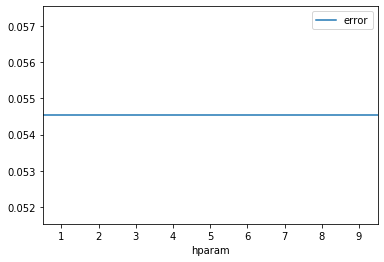

In [23]:
results = pd.DataFrame()
results['hparam'] = hparam['C']
results['error'] = 1 - lgrCV.cv_results_['mean_test_score']
results.plot.line(x='hparam',y='error')

In [24]:
lgr_acc_rate = (lgrCV.best_estimator_.predict(attributes_test) == target_test).mean()

**Weighted Logistic Regression**

In [25]:
wlgr = LogisticRegression(max_iter=1000, class_weight=weight)
hparam = {'C': np.arange(0.5, 10, 0.5)}
wlgrCV = GridSearchCV(wlgr, param_grid=hparam,n_jobs=-1)
wlgrCV.fit(attributes_train,target_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0,
                                          class_weight={0: 1.0574364378869714,
                                                        1: 18.410550458715594},
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5,
       7. , 7.5, 8. , 8.5, 9. , 9.5])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score

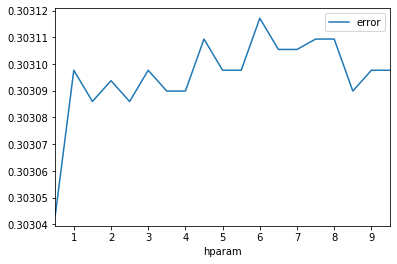

In [26]:
results = pd.DataFrame()
results['hparam'] = hparam['C']
results['error'] = 1 - wlgrCV.cv_results_['mean_test_score']
results.plot.line(x='hparam',y='error')

In [27]:
wlgr_acc_rate = (wlgrCV.best_estimator_.predict(attributes_test) == target_test).mean()

In [28]:
print("logistic regression:", round(lgr_acc_rate, 4))
print("weighted logistic regression:", round(wlgr_acc_rate, 4))

logistic regression: 0.5012
weighted logistic regression: 0.5923


### Decision Tree Comparison

**Decision Tree**

In [29]:
t = DecisionTreeClassifier(random_state=1)
hparam = {'max_depth':range(1,6)}
tCV = GridSearchCV(t, param_grid=hparam, return_train_score=True)
tCV.fit(attributes_train, target_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=1, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': range(1, 6)}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=Tru

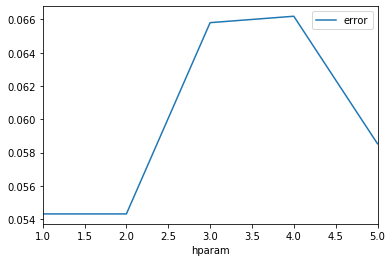

In [30]:
results = pd.DataFrame()
results['hparam'] = hparam['max_depth']
results['error'] = 1 - tCV.cv_results_['mean_test_score']
results.plot.line(x='hparam',y='error')

In [31]:
dt_acc_rate = (tCV.best_estimator_.predict(attributes_test) == target_test).mean()

**Weighed Decision Tree**

In [32]:
wt = DecisionTreeClassifier(random_state=1, class_weight=weight)
hparam = {'max_depth': np.arange(1, 6)}
wtCV = GridSearchCV(wt, param_grid=hparam, return_train_score=True)
wtCV.fit(attributes_train,target_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight={0: 1.0574364378869714,
                                                            1: 18.410550458715594},
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=1, splitter='best'),
             iid='de

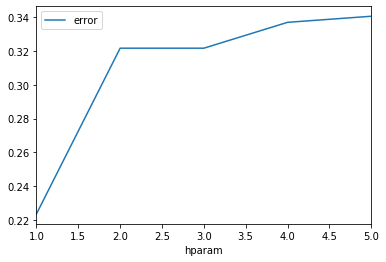

In [33]:
results = pd.DataFrame()
results['hparam'] = hparam['max_depth']
results['error'] = 1 - wtCV.cv_results_['mean_test_score']
results.plot.line(x='hparam',y='error')

In [34]:
wdt_acc_rate = (wtCV.best_estimator_.predict(attributes_test) == target_test).mean()

In [35]:
print("decision classification:", round(dt_acc_rate, 4))
print("weighted decision classification:", round(wdt_acc_rate, 4))

decision classification: 0.5
weighted decision classification: 0.5632


### Random Forest Comparison

In [36]:
forest = RandomForestClassifier(class_weight=weight)
hparam = {'n_estimators':range(5,21)}
forestCV = GridSearchCV(forest, param_grid=hparam, return_train_score=True, n_jobs=-1)
forestCV.fit(attributes_train, target_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight={0: 1.0574364378869714,
                                                            1: 18.410550458715594},
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
         

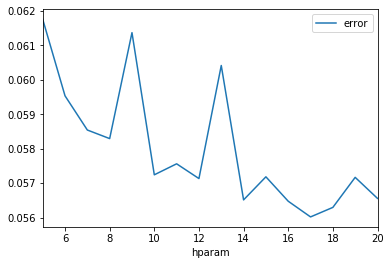

In [37]:
results = pd.DataFrame()
results['hparam'] = hparam['n_estimators']
results['error'] = 1 - forestCV.cv_results_['mean_test_score']
results.plot.line(x='hparam',y='error')

In [38]:
forest_acc_rate = (forestCV.best_estimator_.predict(attributes_test) == target_test).mean()

In [39]:
wforest = RandomForestClassifier(class_weight=weight)
hparam = {'n_estimators':range(5,21)}
wforestCV = GridSearchCV(wforest, param_grid=hparam, return_train_score=True, n_jobs=-1)
wforestCV.fit(attributes_train, target_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight={0: 1.0574364378869714,
                                                            1: 18.410550458715594},
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
         

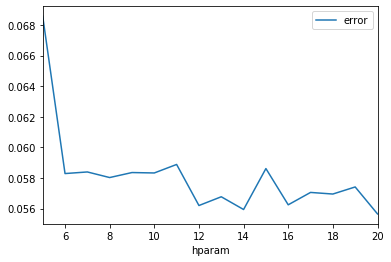

In [40]:
results = pd.DataFrame()
results['hparam'] = hparam['n_estimators']
results['error'] = 1 - wforestCV.cv_results_['mean_test_score']
results.plot.line(x='hparam',y='error')

In [41]:
wforest_acc_rate = (wforestCV.best_estimator_.predict(attributes_test) == target_test).mean()

Text(0.5, 1.0, 'Feature Importance of Random Forest Classification')

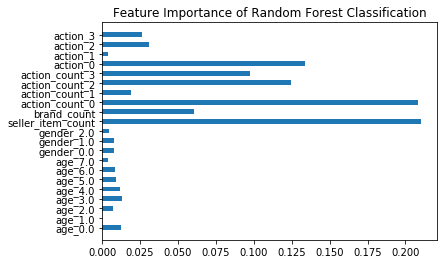

In [42]:
plt.barh(attributes_train.columns.tolist(),
         height=0.5,
         width=forestCV.best_estimator_.feature_importances_,
         align="center")
plt.title("Feature Importance of Random Forest Classification")

Text(0.5, 1.0, 'Feature Importance of Weighted Random Forest Classification')

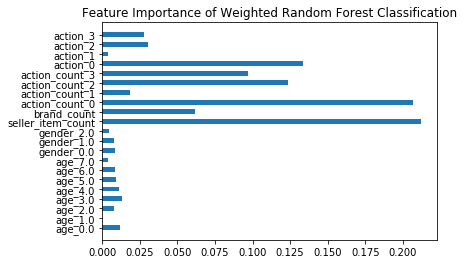

In [43]:
plt.barh(attributes_train.columns.tolist(),
         height=0.5,
         width=wforestCV.best_estimator_.feature_importances_,
         align="center")
plt.title("Feature Importance of Weighted Random Forest Classification")

In [44]:
print("random forest classification:", round(forest_acc_rate, 4))
print("weighted random forest classification:", round(wforest_acc_rate, 4))

random forest classification: 0.5008
weighted random forest classification: 0.4998
